In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from utils import plot_sample
import h2o
from h2o.estimators import H2ODeepLearningEstimator, H2OEstimator
import pandas as pd
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 days 23 hours 5 mins
H2O_cluster_timezone:,Europe/Belgrade
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.5
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_wojciech_blachowski_w86986
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.929 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


# Data

In [2]:
X_full, y_full = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [3]:
positive_idx = y_full.astype(np.int32)%2==0
negative_idx = np.invert(positive_idx)

X_positive, y_positive = X_full[positive_idx], y_full[positive_idx]
X_negative, y_negative = X_full[negative_idx], y_full[negative_idx]

print(f'Number of positive examples: {len(X_positive)}')
print(f'Number of negative examples: {len(X_negative)}')

Number of positive examples: 34418
Number of negative examples: 35582


In [4]:
permutation = np.random.permutation(len(X_negative))[:len(X_positive)]
X_negative, y_negative = X_negative[permutation], y_negative[permutation]

In [5]:
print(f'Number of positive examples: {len(X_positive)}')
print(f'Number of negative examples: {len(X_negative)}')
print(Counter(y_positive).most_common())
print(Counter(y_negative).most_common())

Number of positive examples: 34418
Number of negative examples: 34418
[('2', 6990), ('0', 6903), ('6', 6876), ('8', 6825), ('4', 6824)]
[('1', 7638), ('7', 7048), ('3', 6923), ('9', 6733), ('5', 6076)]


In [6]:
X = np.concatenate((X_positive, X_negative))
y = np.concatenate((np.ones(len(X_positive)), np.zeros(len(X_negative))))
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

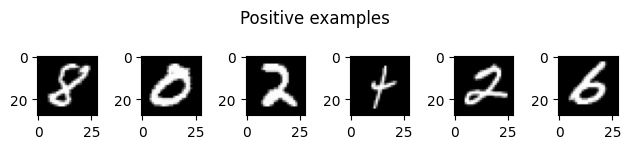

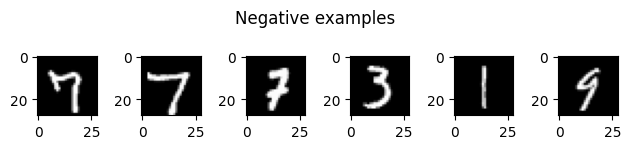

In [7]:
plot_sample(X_positive, "Positive examples")
plot_sample(X_negative, "Negative examples")

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_test, X_calib, y_test, y_calib = train_test_split(X_test, y_test, train_size=0.5)

print(f"Train length: {len(X_train)}")
print(f"Test length: {len(X_test)}")
print(f"Calib length: {len(X_calib)}")

Train length: 55068
Test length: 6884
Calib length: 6884


In [9]:
X_train_unscaled = np.copy(X_train)
X_test_unscaled = np.copy(X_test)
X_calib_unscaled = np.copy(X_calib)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_calib = scaler.transform(X_calib)

# Calibration

In [10]:
def plot_calibration(clf, X, y, save_calibration_model=False, calibration_model_name=None):
    def plot_calibration_curve(ground_truth, probs, title):
        calib_prob_true, calib_prob_pred = calibration_curve(ground_truth, probs, n_bins=10)
        brier_score = brier_score_loss(ground_truth, new_probs)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(*zip(*sorted(zip(*(calib_prob_true, calib_prob_pred)))), marker='.', color='orange')
        plt.title(f'{title}\nBrier score: {round(brier_score, 4)}')
        
    if isinstance(clf, H2OEstimator):
        df = pd.DataFrame(data = [[*data, target] for data, target in zip(X,y) ], columns=[*list(range(len(X[0]))), 'target'])
        h2o_frame =  h2o.H2OFrame(df)
        h2o_frame['target'] = h2o_frame['target'].asfactor()
        overlay_probs = clf.predict(h2o_frame).as_data_frame()['p1'].tolist()
    elif hasattr(clf, "predict_proba"):
        overlay_probs = clf.predict_proba(X)[:, 1]
    else:  # use decision function
        overlay_probs = clf.decision_function(X)
        overlay_probs = (overlay_probs - overlay_probs.min()) / (overlay_probs.max() - overlay_probs.min())

    ground_truth = y
    prob_true, prob_pred = calibration_curve(ground_truth, overlay_probs, n_bins=10)
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(hspace=0.4) 

    plt.subplot(3,2,1)
    brier_score = brier_score_loss(ground_truth, overlay_probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(prob_pred, prob_true, marker='.', color='orange')
    plt.title(f'Before calibration\nBrier score: {round(brier_score, 4)}')
    
    plt.subplot(3,2,3)
    prob_pred_calib, alpha, beta = platt_scaling(prob_pred, prob_true)
    plt.plot([0, 1], [0, 1], alpha=0)
    plt.plot(prob_pred, prob_true, marker='.', color='orange')
    plt.plot(prob_pred, prob_pred_calib, color='red')
    plt.title(f'Fitted logistic regression')
    
    plt.subplot(3,2,4)
    new_probs = 1 / (1 + np.exp(alpha * np.array(overlay_probs) + beta))
    plot_calibration_curve(ground_truth, new_probs, 'After calibration with Platt scaling')
    
    plt.subplot(3,2,5)
    isotonic_model = isotonic_regression(prob_pred, prob_true)
    plt.plot([0, 1], [0, 1], alpha=0)
    plt.plot(prob_pred, prob_true, marker='.', color='orange')
    plt.plot(isotonic_model.X_thresholds_, isotonic_model.y_thresholds_, color='red')
    plt.title(f'Fitted isotonic regression')
    
    plt.subplot(3,2,6)
    new_probs = isotonic_model.predict(overlay_probs)
    plot_calibration_curve(ground_truth, new_probs, 'After calibration with isotonic regression')
    plt.show()

def platt_scaling(prob_pred, prob_true):
    prob_pred_2, prob_true_2 = list(zip(*[p for p in zip(prob_pred, prob_true) if 0<p[1]<1]))
    prob_true_2 = np.log((1 / np.array(prob_true_2)) - 1)
    prob_pred_2= np.array(prob_pred_2)
    model = LinearRegression().fit(prob_pred_2.reshape(-1, 1), prob_true_2.reshape(-1, 1))
    alpha = model.coef_[0, 0]
    beta = model.predict([[0]])[0, 0]
    return 1 / (1 + np.exp(alpha * np.array(prob_pred) + beta)), alpha, beta

def isotonic_regression(prob_pred, prob_true):
    return IsotonicRegression(out_of_bounds='clip').fit(prob_pred, prob_true)

In [11]:
def to_h2o_frame(X, y):
    df = pd.DataFrame(data = [[*data, target] for data, target in zip(X,y) ], columns=[*list(range(len(X[0]))), 'target'])
    h2o_frame =  h2o.H2OFrame(df)
    h2o_frame['target'] = h2o_frame['target'].asfactor()
    return h2o_frame

train = to_h2o_frame(X_train, y_train)
test = to_h2o_frame(X_test, y_test)
calib = to_h2o_frame(X_calib, y_calib)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [29]:
dl = H2ODeepLearningEstimator()
dl.train(x=[str(x) for x in range(len(X_train[0]))],
         y="target",
         training_frame=train,
         validation_frame=test)

#first is threshold, second is accuracy
accuracy = dl.model_performance(test).accuracy()
print(f"Valid accuracy: {round(100*accuracy[0][1],2)}%")

C:\Users\wojciech.blachowski\Miniconda3\envs\calibration\lib\site-packages\h2o\estimators\estimator_base.py:201: RuntimeWarning: Dropping bad and constant columns: [392, 196, 671, 111, 672, 112, 673, 113, 476, 753, 754, 755, 756, 757, 758, 759, 52, 53, 10, 54, 11, 55, 56, 57, 16, 17, 18, 19, 560, 0, 1, 2, 3, 168, 4, 5, 6, 644, 7, 645, 8, 9, 727, 728, 20, 729, 21, 22, 23, 24, 25, 26, 27, 28, 29, 730, 699, 616, 30, 31, 32, 140, 141, 780, 781, 782, 783, 588, 700, 701, 82, 83, 84, 85]
  warnings.warn(mesg["message"], RuntimeWarning)


Valid accuracy: 98.36%


C:\Users\wojciech.blachowski\Miniconda3\envs\calibration\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic, score: 0.8986054619407321
Naive Bayes, score: 0.7611853573503777


C:\Users\wojciech.blachowski\Miniconda3\envs\calibration\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Support Vector Classification, score: 0.8875653689715282
Random Forest, score: 0.9773387565368972
MLP, score: 0.9815514235909355
Logistic


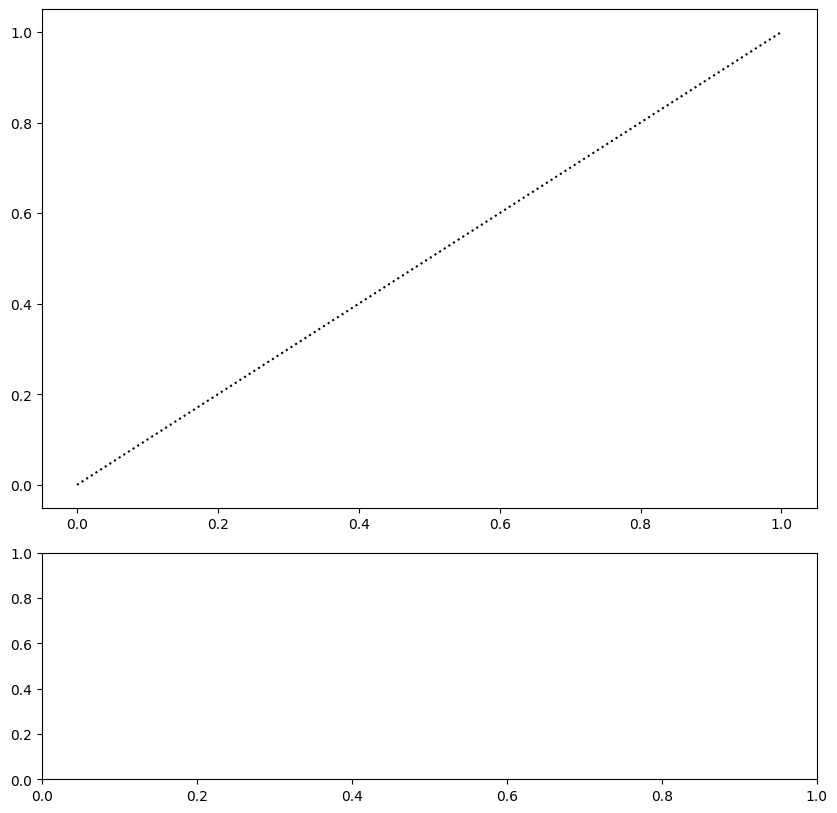

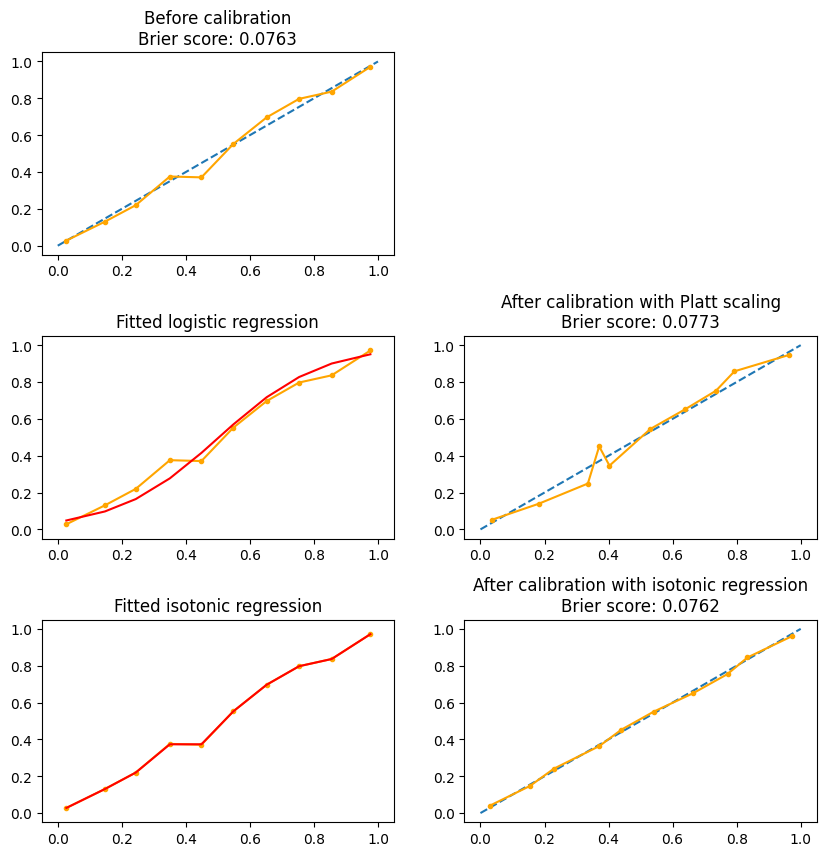

Naive Bayes


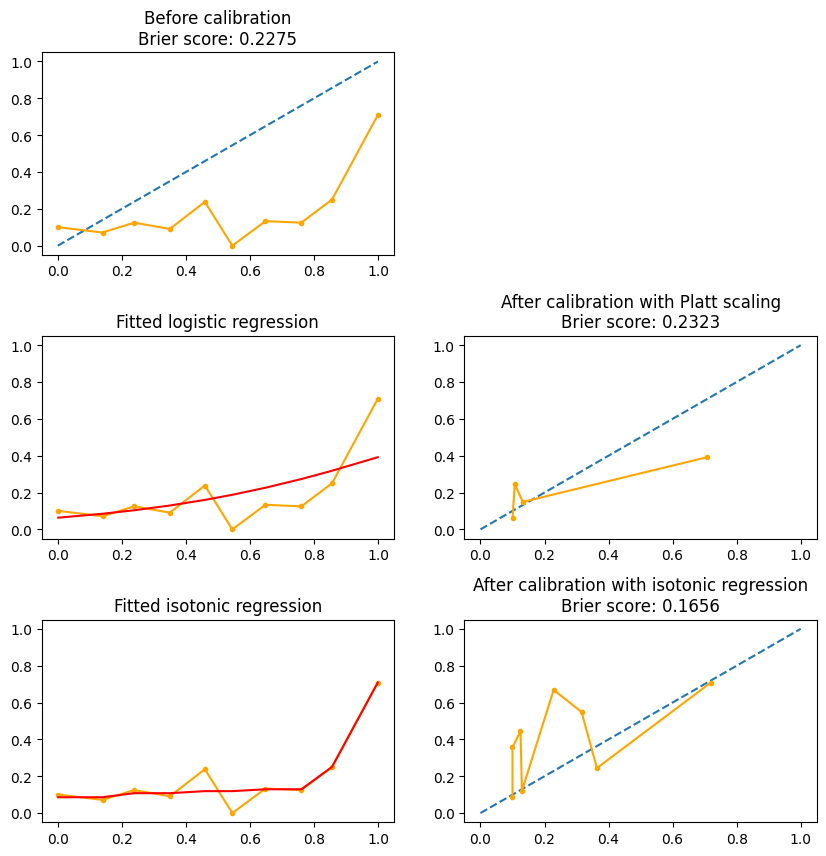

Support Vector Classification


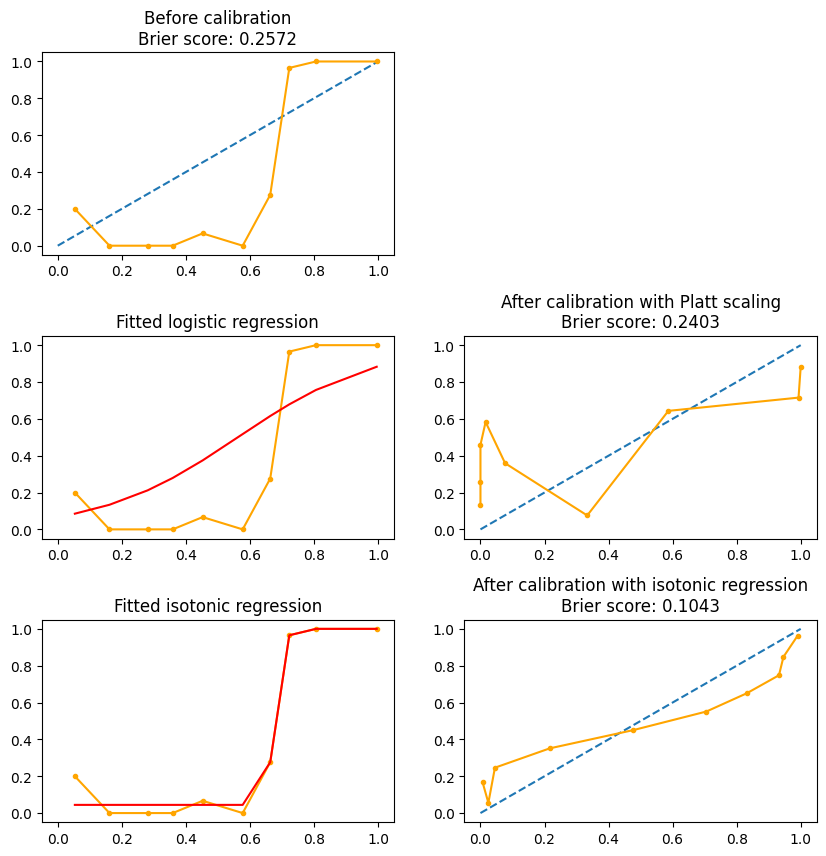

Random Forest


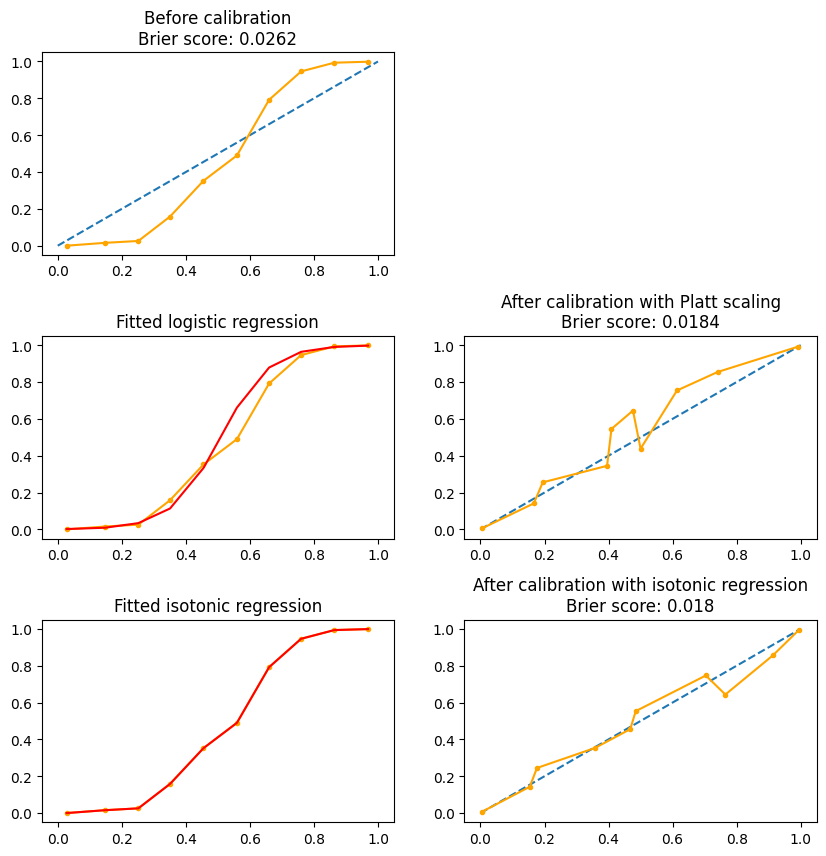

MLP


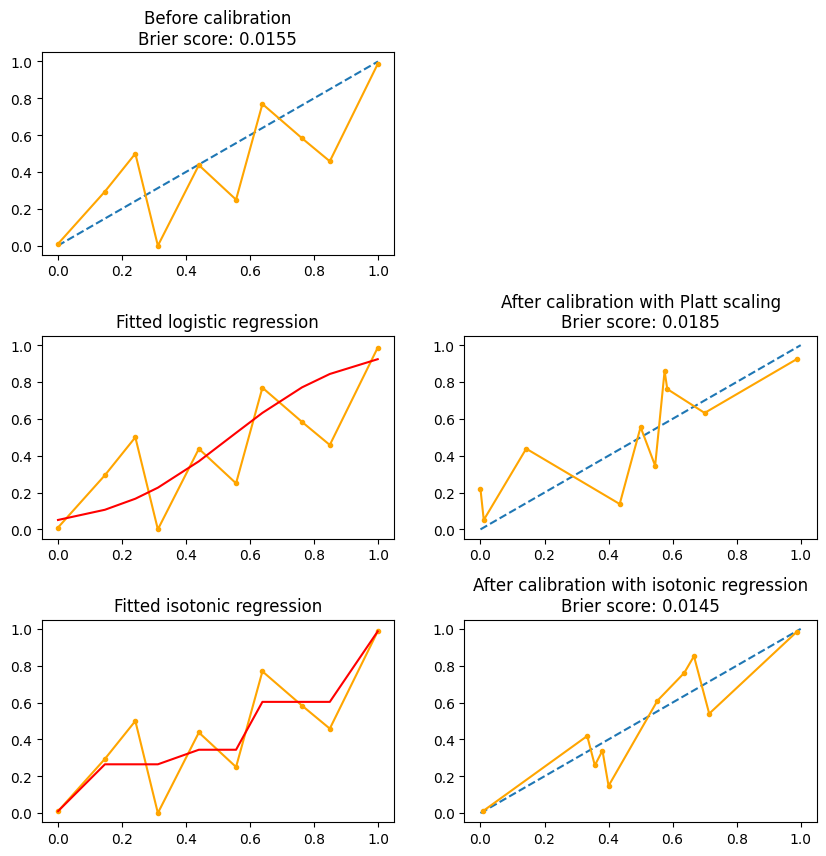

H2O Deep Learning
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


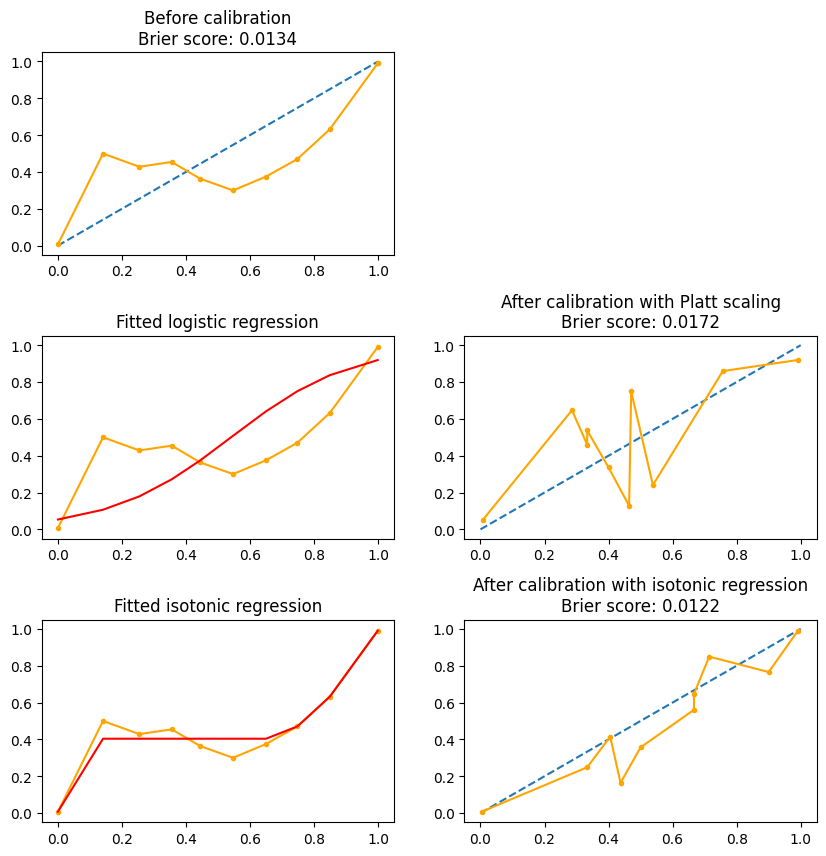

In [13]:
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier()

for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    print(f'{name}, score: {clf.score(X_test, y_test)}')
    
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                 (dl, 'H2O Deep Learning')]:
    print(name)
    plot_calibration(clf, X_calib, y_calib)

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


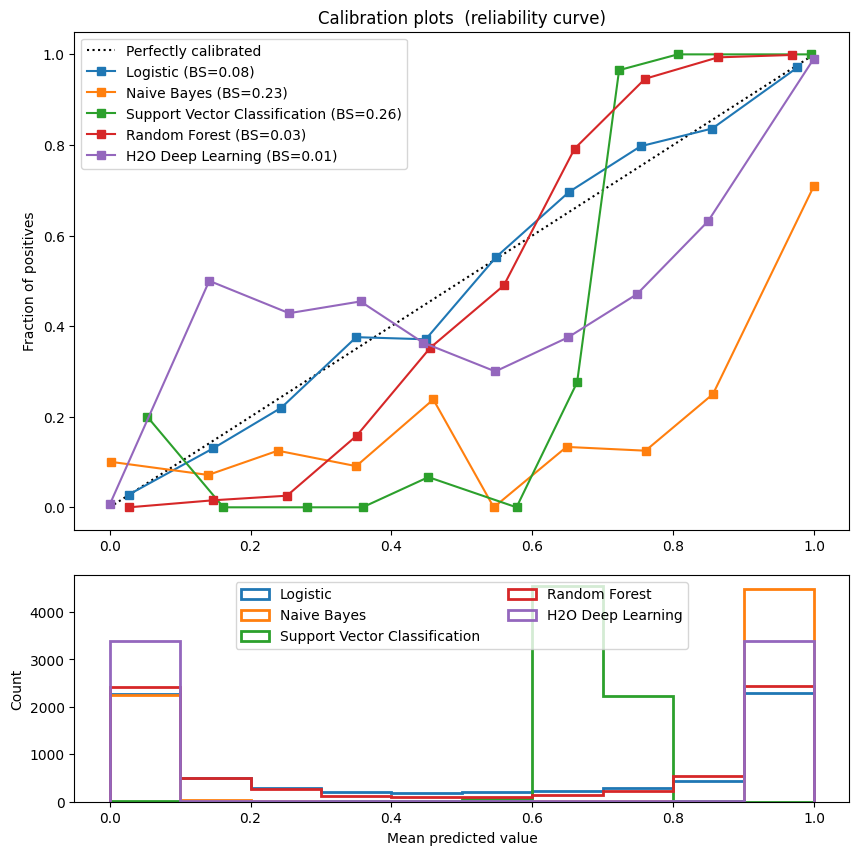

In [24]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                  (dl, 'H2O Deep Learning')]:
    if isinstance(clf, H2OEstimator):
        df = pd.DataFrame(data = [[*data, target] for data, target in zip(X_calib,y_calib) ], columns=[*list(range(len(X_calib[0]))), 'target'])
        h2o_frame =  h2o.H2OFrame(df)
        h2o_frame['target'] = h2o_frame['target'].asfactor()
        prob_pos = clf.predict(h2o_frame).as_data_frame()['p1'].tolist()
    elif hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_calib)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_calib)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_calib, prob_pos, n_bins=10)
    brier_score = brier_score_loss(y_calib, prob_pos)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label=f"{name} (BS={round(brier_score, 2)})")

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper left")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
plt.show()